# The Agent-Environment Interaction
### Start by implementing a class for the Gridworld environment.



In [376]:
import numpy as np

class Gridworld:
    def __init__(self,predator , food, time):
        self.predator = predator
        self.food = food
        self.time = time
        self.num_rows = 3
        self.num_cols = 3
        self.num_cells = self.num_cols * self.num_rows
        self.random_move_probability = 0 # with random_move_probability p, the agent moves randomly in any of the 4 directions. Otherwise, the agent moves in the intended direction. Set to 0, the agent always moves as intended.
        
        # Choose starting position of the 
        self.agent_position = np.random.randint(0,8) # agent spawns randomly in environment
        
        # Choose position of the gold and predator
        self.predator_positions = np.array([5])
        self.food_positions = np.array([8]) # position 8 corresponds to top right in a 3x3 grid, position 5 is just beneath 8.

        
        self.terminal_states = np.array([self.food_positions]) # terminal state indicate that the agent should be respawned
        
        # Specify rewards
        self.rewards = np.zeros(self.num_cells)
        self.rewards[self.predator_positions] = self.predator
        self.rewards[self.food_positions] = self.food
        
        # Specify available actions
        self.actions = ["UP", "RIGHT", "DOWN", "LEFT"]
        self.num_actions = len(self.actions)
    
    def get_available_actions(self):
        return self.actions
    def return_time_reward(self):
        return self.time


    ### make_step moves the agent in the direction of the action they select. If the agent hits a wall, it stays where it was. Return the reward of the state you end up in.
    def make_step(self, action):
        # Store the old position for reference
        old_pos = self.agent_position
        
        # Calculate new position based on the action
        if action == 0:  # UP
            # Move up only if not in the top row
            if self.agent_position <= 5:
                new_pos = self.agent_position + 3
            else:
                new_pos = old_pos  # Stay in place if move is not possible

        elif action == 1:  # RIGHT
            # Move right only if not in the right column
            if (self.agent_position + 1) % 3 != 0:
                new_pos = self.agent_position + 1
            else:
                new_pos = old_pos  # Stay in place if move is not possible

        elif action == 2:  # DOWN
            # Move down only if not in the bottom row
            if self.agent_position >= 3:
                new_pos = self.agent_position - 3
            else:
                new_pos = old_pos  # Stay in place if move is not possible

        elif action == 3:  # LEFT
            # Move left only if not in the left column
            if self.agent_position % 3 != 0:
                new_pos = self.agent_position - 1
            else:
                new_pos = old_pos  # Stay in place if move is not possible

        # Update the agent's position if the new position is within bounds
        if new_pos >= 0 and new_pos <= 8:
            self.agent_position = new_pos
        

        return self.rewards[self.agent_position]  


Note that we chose to specify the cells in a one-dimensional array instead of a two-dimensional array (e.g., the bomb is at position `8` and not at position `[2,2]` in a two-dimensional array). 


## Define a new class that implements a Q-learning Agent


In [377]:
import random
random.seed(43)
from random import randint, random
from operator import add
import numpy as np

class Q_learning():
    def __init__(self):
        self.eps = 0.3 # controls the level of exploration
        
        self.step = 0.2  # how big is the update step
        self.gamma = 0.99 # this is the discount factor
        self.q_values = np.ones((4,9)) # for each of the 9 states, we want to evaluate the value of taking each of the 4 actions in each state
    
    # choose_action_learning is the action selection policy the agent uses to find the optimal policy, e.g., exploring (taking random actions) every so often
    def choose_action_learning(self, state, available_actions):
        if  random() < self.eps:
            
            number_of_actions = len(available_actions)
            random_action_index = np.random.randint(0, number_of_actions)
            return random_action_index
        else:  
            action = np.argmax(self.q_values[:,state])
            return action
        
    # choose_action_optimal is the action selection policy used by the agent which has already converged to the optimal polict and which no longer needs to explore
    def choose_action_optimal(self, state, available_actions):
            return  np.argmax(self.q_values[:,state])
            
        
    # update_values implements the Q-learning update rule
    def update_values(self,chosen_action,curr_pos, next_pos, reward):
        current_pos = curr_pos
        next_pos = next_pos
        self.q_values[chosen_action][current_pos] = self.q_values[chosen_action][current_pos] + self.step*(reward + self.gamma*max(self.q_values[:, next_pos]) - self.q_values[chosen_action][current_pos])



# Check the GridWorld and Q-learning agent works as expected

In [378]:
env = Gridworld(-10, 10, 0)
agent = Q_learning()

available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
print("Current position of the agent =", env.agent_position)
chosen_action = agent.choose_action_optimal(env.agent_position, available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("New position of the agent =", env.agent_position)

Available_actions = ['UP', 'RIGHT', 'DOWN', 'LEFT']
Current position of the agent = 2
Randomly chosen action = 0
Reward obtained = -10.0
New position of the agent = 5


# Define a fitness function which evaluates the fitness of an optimal agent w.r.t a reward function

In [518]:
def fitness(individual): # the indiviual is the parameters of the reward function, indvidudual = [r_p, r_f, r_t]
    predator_cost = 100
    num_iterations_learn = 10000
    life_span = 1000

    predator, food, time = individual[0],individual[1],individual[2]
    env = Gridworld(predator,food,time)

    agent = Q_learning()
    available_actions = env.get_available_actions()

    count_grid = np.zeros((4,9)) #counts the number of times each state-action pari was visited - for debugging



    ###############################
    ## first we need to train the agent to learn the optimal policy, using choose_action_learning
    ###############################
    steps = 0
    while steps < num_iterations_learn:  # assume training will have converged after 10000 steps, this is safe for a 3x3 gridworld
        env = Gridworld(predator,food,time) # spawn the agent in the env

        while True and steps < num_iterations_learn: # if the agent is not at the food, and is still alive, the agent needs to choose an action and take a step
            curr_pos = env.agent_position
            if curr_pos in env.terminal_states:
                break
            chosen_action = agent.choose_action_learning(curr_pos, available_actions) #choose_action_learning -> explore while learning
            reward = env.make_step(chosen_action) + time
            steps += 1
            
            next_pos = env.agent_position
            #after choosing an action and taking a step, we need to update the agent's q_table
            agent.update_values(chosen_action, curr_pos, next_pos, reward)
            


        #### note: this code below adds the cost to the agents lifetime of hitting the predator. However, as discussed in the google docs, this will have no influence of the strategy the agent learns, so we can avoid it while training. It is only necessary to include in evaluation so evolution can learn to select reward fucntions which punish the predator.
            ### add cost of hitting predator
            #if env.agent_position == 5:
             #   steps += predator_cost

            count_grid[chosen_action][curr_pos] +=1

            


    ##############################################
    ## Now we have an optimal agent (or optimal q_table), we want to evaluate the agent's fitness
    ############################
    
    # we are also now interested in logging the rewards the agent receives over its life
    rewards = [] # all rewards collected
    ep_rewards = [] # rewards collected each epsiode (before the agent respawns)
    sum_reward = 0
    steps = 0 
    food_collected = 0
    while steps < life_span:
        epsiode_reward = 0
        env = Gridworld(predator,food,time)
        while env.agent_position not in env.terminal_states and steps < life_span:
            curr_pos = env.agent_position
            chosen_action = agent.choose_action_optimal(curr_pos, available_actions) # choose_action_optimal -> exploit while evaluation
            reward = env.make_step(chosen_action) + time
            steps += 1
            epsiode_reward += reward

            sum_reward += reward

            # update the fitness score if the agent reaches the food
            if env.agent_position in env.terminal_states:
                food_collected += 1

            ### add cost of hitting predator
            if env.agent_position == 5:
                steps += predator_cost

            rewards.append(reward)
            
        ep_rewards.append(epsiode_reward)

    Q = agent.q_values
    return food_collected #, Q # , count_grid, sum_reward

# plot_policy is a function to visualise the strategy the agent is current taking

In [508]:
import matplotlib.pyplot as plt
def plot_policy(Q):
    # Define action mappings and directions for plotting arrows
    actions = ['Up', 'Right', 'Down', 'Left']
    directions = np.array([[0, 1], [1, 0], [0, -1], [-1, 0]])  # dy, dx for Up, Right, Down, Left
    
    # Determine the best action for each state
    best_actions = np.argmax(Q, axis=0)
    
    # Create a 3x3 grid
    grid = np.arange(9).reshape((3, 3))
    
    # Plotting setup
    fig, ax = plt.subplots()
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(-0.5, 2.5)
    ax.set_xticks(np.arange(3))
    ax.set_yticks(np.arange(3))
    ax.grid(which='both')
    
    # Add arrows for best actions
    for index in range(9):
        action_index = best_actions[index]
        x = index % 3
        y = index // 3
        dx, dy = directions[action_index]
        ax.arrow(x, y, dx*0.3, dy*0.3, head_width=0.1, head_length=0.1, fc='k', ec='k')
    
    plt.show()

# Test 


In [514]:
collect, Q , cg, sum_reward, steps= fitness([10,10,0])
print('fitness score = ', collect)
print('sum_reward = ', sum_reward)
print('steps = ', steps)


fitness score =  0
sum_reward =  100.0
steps =  10000


# Plot the reward function against fitness for a range of values

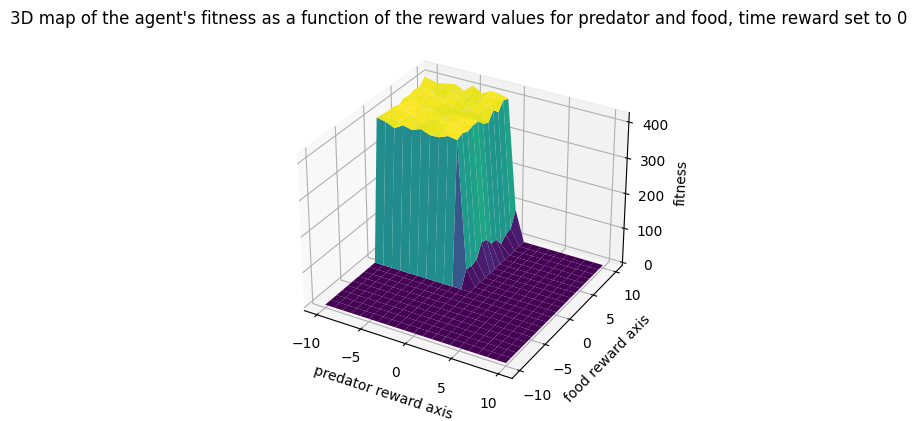

In [520]:
# generate grid of all possible values for bomb, gold reward

x = np.linspace(-10, 10, 21)
y = np.linspace(-10, 10, 21)

x, y = np.meshgrid(x, y)
#z = np.array([fitness([xi, yi, 0]) for xi, yi in zip(np.ravel(x), np.ravel(y))]).reshape(x.shape)
z2 = np.array([fitness([xi, yi, 0]) for xi, yi in zip(np.ravel(x), np.ravel(y))]).reshape(x.shape)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a surface plot
#surf = ax.plot_surface(x, y, z, cmap='viridis')
surf2 = ax.plot_surface(x, y, z2, cmap='viridis')

# Add a color bar which maps values to colors
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.title("3D map of the agent's fitness as a function of the reward values for predator and food, time reward set to 0 ")
ax.set_xlabel('predator reward axis')
ax.set_ylabel('food reward axis')
ax.set_zlabel('fitness')

plt.show()

#plot episode reward

# In the case of needing to use a genetic algroithm. This is code I would start with

In [ ]:

def individual(length, min, max):
    """Create a member of the population."""
    return [randint(min, max) for _ in range(length)]

def population(count, length, min, max):
    """Create a number of individuals (i.e., a population)."""
    return [individual(length, min, max) for _ in range(count)]

def evolve(pop, retain, random_select , mutate):
   # print(pop)
    #print([(fitness(x), x) for x in pop])
    graded = [(fitness(x), x) for x in pop]
    print('graded unsorted', graded)
    graded = [x[1] for x in sorted(graded, reverse=True)]
    print('graded', graded)
    retain_length = int(len(graded) * retain)
    # so that we always retain atleast 1 individaul:
    if retain_length == 0:
        retain_length =1
    
    parents = graded[:retain_length]
    for individual in graded[retain_length:]:
        if random_select > random():
            parents.append(individual)
   

    for individual in parents:
        # If mutate is initialised, the inidvidual changes their value up to 5 points randomly.
        if mutate > random():
            pos_to_mutate = randint(0, len(individual) - 1)
            individual[pos_to_mutate] = randint(min(individual)-5, max(individual)+5)
    parents_length = len(parents)
    desired_length = len(pop) - parents_length
    children = []

    while len(children) < desired_length:
        male = randint(0, parents_length - 1)
        female = randint(0, parents_length - 1)

        # new way to choose children, take average of parents and add +-1 or 0 to enhance mutation
        male = parents[male]
        female = parents[female]
        child = []
        child.append(male[0])
        child.append(female[1])
        if random() < 0.5:
            child.append(male[2])
        else:
            child.append(female[2])
        children.append(child)
       
    parents.extend(children)
    return parents
